# Models


This is an introduction and overview on how to work with models in Gammapy. 

The sub-package `~gammapy.modeling` contains all the functionality related to modeling and fitting
data. This includes spectral, spatial and temporal model classes, as well as the fit
and parameter API. We will cover the following topics in order:

1. [Spectral Models](#Spectral-Models)
1. [Spatial Models](#Spatial-Models)
1. [Temporal Models](#Temporal-Models)
1. [SkyModel](#SkyModel)
1. [Modifying model parameters](#Modifying-model-parameters)
1. [Model Lists and Serialisation](#Model-Lists-and-Serialisation)
1. [Models with shared parameter](#Models-with-shared-parameter)
1. [Implementing as Custom Model](#Implementing-a-Custom-Model)
1. [Energy dependent spatial models](#Models-with-energy-dependent-morphology)
1. [Energy dependent temporal models](#Spectrally-varying-temporal-models)

The models follow a naming scheme which contains the category as a suffix to the class name. An overview of all the available models can be found in the [model gallery](../../modeling/gallery/index.rst#spectral-models).

Note that there are separate tutorials, [model_management](model_management.ipynb) and [fitting](fitting.ipynb) that explains about `~gammapy.modeling`,
the Gammapy modeling and fitting framework. You have to read that to learn how to work with models in order to analyse data.



## Setup

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from astropy import units as u
from gammapy.maps import Map, WcsGeom, MapAxis

## Spectral models

All models are imported from the `~gammapy.modeling.models` namespace. Let's start with a `PowerLawSpectralModel`:

In [3]:
from gammapy.modeling.models import PowerLawSpectralModel

In [4]:
pwl = PowerLawSpectralModel()
print(pwl)

PowerLawSpectralModel

  type      name     value         unit        error   min max frozen link
-------- --------- ---------- -------------- --------- --- --- ------ ----
spectral     index 2.0000e+00                0.000e+00 nan nan  False     
spectral amplitude 1.0000e-12 cm-2 s-1 TeV-1 0.000e+00 nan nan  False     
spectral reference 1.0000e+00            TeV 0.000e+00 nan nan   True     


To get a list of all available spectral models you can import and print the spectral model registry or take a look at the [model gallery](https://docs.gammapy.org/dev/modeling/gallery/index.html#spectral-models):

In [5]:
from gammapy.modeling.models import SPECTRAL_MODEL_REGISTRY

print(SPECTRAL_MODEL_REGISTRY)

Registry
--------

ConstantSpectralModel                     : ['ConstantSpectralModel', 'const'] 
CompoundSpectralModel                     : ['CompoundSpectralModel', 'compound'] 
PowerLawSpectralModel                     : ['PowerLawSpectralModel', 'pl'] 
PowerLaw2SpectralModel                    : ['PowerLaw2SpectralModel', 'pl-2'] 
BrokenPowerLawSpectralModel               : ['BrokenPowerLawSpectralModel', 'bpl'] 
SmoothBrokenPowerLawSpectralModel         : ['SmoothBrokenPowerLawSpectralModel', 'sbpl'] 
PiecewiseNormSpectralModel                : ['PiecewiseNormSpectralModel', 'piecewise-norm'] 
ExpCutoffPowerLawSpectralModel            : ['ExpCutoffPowerLawSpectralModel', 'ecpl'] 
ExpCutoffPowerLaw3FGLSpectralModel        : ['ExpCutoffPowerLaw3FGLSpectralModel', 'ecpl-3fgl'] 
SuperExpCutoffPowerLaw3FGLSpectralModel   : ['SuperExpCutoffPowerLaw3FGLSpectralModel', 'secpl-3fgl'] 
SuperExpCutoffPowerLaw4FGLDR3SpectralModel: ['SuperExpCutoffPowerLaw4FGLDR3SpectralModel', 'secpl-4fgl-d

Spectral models all come with default parameters. Different parameter
values can be passed on creation of the model, either as a string defining
the value and unit or as an `astropy.units.Quantity` object directly:

In [6]:
amplitude = 1e-12 * u.Unit("TeV-1 cm-2 s-1")
pwl = PowerLawSpectralModel(amplitude=amplitude, index=2.2)

For convenience a `str` specifying the value and unit can be passed as well:

In [7]:
pwl = PowerLawSpectralModel(amplitude="2.7e-12 TeV-1 cm-2 s-1", index=2.2)
print(pwl)

PowerLawSpectralModel

  type      name     value         unit        error   min max frozen link
-------- --------- ---------- -------------- --------- --- --- ------ ----
spectral     index 2.2000e+00                0.000e+00 nan nan  False     
spectral amplitude 2.7000e-12 cm-2 s-1 TeV-1 0.000e+00 nan nan  False     
spectral reference 1.0000e+00            TeV 0.000e+00 nan nan   True     


The model can be evaluated at given energies by calling the model instance:

In [8]:
energy = [1, 3, 10, 30] * u.TeV
dnde = pwl(energy)
print(dnde)

[2.70000000e-12 2.40822469e-13 1.70358483e-14 1.51948705e-15] 1 / (cm2 s TeV)


The returned quantity is a differential photon flux. 

For spectral models you can additionally compute the integrated and energy flux
in a given energy range:

In [9]:
flux = pwl.integral(energy_min=1 * u.TeV, energy_max=10 * u.TeV)
print(flux)

eflux = pwl.energy_flux(energy_min=1 * u.TeV, energy_max=10 * u.TeV)
print(eflux)

2.108034597491956e-12 1 / (cm2 s)
4.982075849517389e-12 TeV / (cm2 s)


This also works for a list or an array of integration boundaries:

In [10]:
energy = [1, 3, 10, 30] * u.TeV
flux = pwl.integral(energy_min=energy[:-1], energy_max=energy[1:])
print(flux)

[1.64794383e-12 4.60090769e-13 1.03978226e-13] 1 / (cm2 s)


In some cases it can be useful to find use the inverse of a spectral model, to find the energy at which a given flux is reached:

In [11]:
dnde = 2.7e-12 * u.Unit("TeV-1 cm-2 s-1")
energy = pwl.inverse(dnde)
print(energy)

1.0 TeV


As a convenience you can also plot any spectral model in a given energy range:

<AxesSubplot:xlabel='Energy [TeV]', ylabel='dnde [1 / (cm2 s TeV)]'>

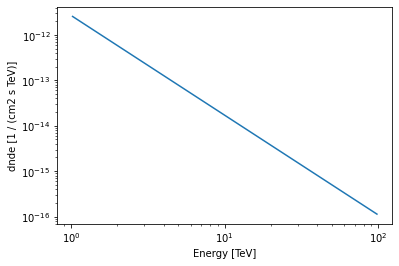

In [12]:
pwl.plot(energy_bounds=[1, 100] * u.TeV)

### Norm Spectral Models

Normed spectral models are a special class of Spectral Models, which have a dimension-less normalisation. These spectral models feature a norm parameter instead
of amplitude and are named using the ``NormSpectralModel`` suffix. They **must** be used along with another spectral model, as a multiplicative correction factor according to their spectral shape. They can be typically used for adjusting template based models, or adding a EBL correction to some analytic model. 

To check if a given `SpectralModel` is a norm model, you can simply look at the `is_norm_spectral_model` property

In [13]:
# To see the available norm models shipped with gammapy:
for model in SPECTRAL_MODEL_REGISTRY:
    if model.is_norm_spectral_model:
        print(model)

<class 'gammapy.modeling.models.spectral.PiecewiseNormSpectralModel'>
<class 'gammapy.modeling.models.spectral.EBLAbsorptionNormSpectralModel'>
<class 'gammapy.modeling.models.spectral.PowerLawNormSpectralModel'>
<class 'gammapy.modeling.models.spectral.LogParabolaNormSpectralModel'>
<class 'gammapy.modeling.models.spectral.ExpCutoffPowerLawNormSpectralModel'>


As an example, we see the `PowerLawNormSpectralModel`

In [14]:
from gammapy.modeling.models import PowerLawNormSpectralModel

In [15]:
pwl_norm = PowerLawNormSpectralModel(tilt=0.1)
print(pwl_norm)

PowerLawNormSpectralModel

  type      name     value    unit   error   min max frozen link
-------- --------- ---------- ---- --------- --- --- ------ ----
spectral      norm 1.0000e+00      0.000e+00 nan nan  False     
spectral      tilt 1.0000e-01      0.000e+00 nan nan   True     
spectral reference 1.0000e+00  TeV 0.000e+00 nan nan   True     


We can check the correction introduced at each energy 

In [16]:
energy = [0.3, 1, 3, 10, 30] * u.TeV
pwl_norm(energy)

<Quantity [1.12794487, 1.        , 0.89595846, 0.79432823, 0.7116851 ]>

A typical use case of a norm model would be in applying spectral correction to a `TemplateSpectralModel`. A template model is defined by custom tabular values provided at initialization. 

In [17]:
from gammapy.modeling.models import TemplateSpectralModel

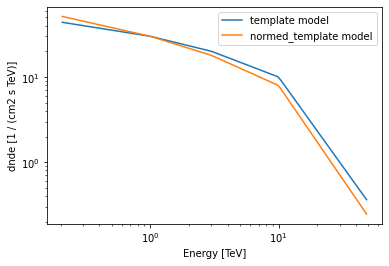

In [18]:
energy = [0.3, 1, 3, 10, 30] * u.TeV
values = [40, 30, 20, 10, 1] * u.Unit("TeV-1 s-1 cm-2")
template = TemplateSpectralModel(energy, values)
template.plot(energy_bounds=[0.2, 50] * u.TeV, label="template model")
normed_template = template * pwl_norm
normed_template.plot(
    energy_bounds=[0.2, 50] * u.TeV, label="normed_template model"
)
plt.legend();

### Compound Spectral Model

A `CompoundSpectralModel` is an arithmetic combination of two spectral models. The model `normed_template` created in the preceding example is an example of a `CompoundSpectralModel`


In [19]:
print(normed_template)

CompoundSpectralModel
    Component 1 : TemplateSpectralModel

    Component 2 : PowerLawNormSpectralModel

  type      name     value    unit   error   min max frozen link
-------- --------- ---------- ---- --------- --- --- ------ ----
spectral      norm 1.0000e+00      0.000e+00 nan nan  False     
spectral      tilt 1.0000e-01      0.000e+00 nan nan   True     
spectral reference 1.0000e+00  TeV 0.000e+00 nan nan   True     
    Operator : mul



To create an additive model, you can do simply:

In [20]:
model_add = pwl + template
print(model_add)

CompoundSpectralModel
    Component 1 : PowerLawSpectralModel

  type      name     value         unit        error   min max frozen link
-------- --------- ---------- -------------- --------- --- --- ------ ----
spectral     index 2.2000e+00                0.000e+00 nan nan  False     
spectral amplitude 2.7000e-12 cm-2 s-1 TeV-1 0.000e+00 nan nan  False     
spectral reference 1.0000e+00            TeV 0.000e+00 nan nan   True     
    Component 2 : TemplateSpectralModel

    Operator : add



## Spatial models

Spatial models are imported from the same `~gammapy.modeling.models` namespace, let's start with a `GaussianSpatialModel`:

In [21]:
from gammapy.modeling.models import GaussianSpatialModel

In [22]:
gauss = GaussianSpatialModel(lon_0="0 deg", lat_0="0 deg", sigma="0.2 deg")
print(gauss)

GaussianSpatialModel

  type   name   value    unit   error      min        max    frozen link
------- ----- ---------- ---- --------- ---------- --------- ------ ----
spatial lon_0 0.0000e+00  deg 0.000e+00        nan       nan  False     
spatial lat_0 0.0000e+00  deg 0.000e+00 -9.000e+01 9.000e+01  False     
spatial sigma 2.0000e-01  deg 0.000e+00  0.000e+00       nan  False     
spatial     e 0.0000e+00      0.000e+00  0.000e+00 1.000e+00   True     
spatial   phi 0.0000e+00  deg 0.000e+00        nan       nan   True     


Again you can check the `SPATIAL_MODELS` registry to see which models are available or take a look at the [model gallery](https://docs.gammapy.org/dev/modeling/gallery/index.html#spatial-models).

In [23]:
from gammapy.modeling.models import SPATIAL_MODEL_REGISTRY

print(SPATIAL_MODEL_REGISTRY)

Registry
--------

ConstantSpatialModel           : ['ConstantSpatialModel', 'const'] 
TemplateSpatialModel           : ['TemplateSpatialModel', 'template'] 
DiskSpatialModel               : ['DiskSpatialModel', 'disk'] 
GaussianSpatialModel           : ['GaussianSpatialModel', 'gauss'] 
GeneralizedGaussianSpatialModel: ['GeneralizedGaussianSpatialModel', 'gauss-general'] 
PointSpatialModel              : ['PointSpatialModel', 'point'] 
ShellSpatialModel              : ['ShellSpatialModel', 'shell'] 
Shell2SpatialModel             : ['Shell2SpatialModel', 'shell2'] 



The default coordinate frame for all spatial models is ``"icrs"``, but the frame can be modified using the
``frame`` argument:

In [24]:
gauss = GaussianSpatialModel(
    lon_0="0 deg", lat_0="0 deg", sigma="0.2 deg", frame="galactic"
)

You can specify any valid `astropy.coordinates` frame. The center position of the model can be retrieved as a `astropy.coordinates.SkyCoord` object using `SpatialModel.position`: 

In [25]:
print(gauss.position)

<SkyCoord (Galactic): (l, b) in deg
    (0., 0.)>


Spatial models can be evaluated again by calling the instance:

In [26]:
lon = [0, 0.1] * u.deg
lat = [0, 0.1] * u.deg

flux_per_omega = gauss(lon, lat)
print(flux_per_omega)

[13061.88470839 10172.60603928] 1 / sr


The returned quantity corresponds to a surface brightness. Spatial model
can be also evaluated using `~gammapy.maps.Map` and `~gammapy.maps.Geom` objects:

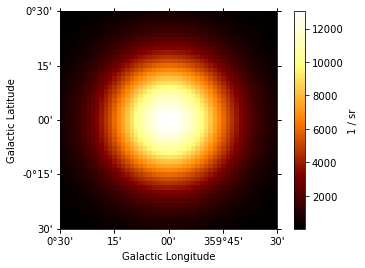

In [27]:
m = Map.create(skydir=(0, 0), width=(1, 1), binsz=0.02, frame="galactic")
m.quantity = gauss.evaluate_geom(m.geom)
m.plot(add_cbar=True);

Again for convenience the model can be plotted directly:

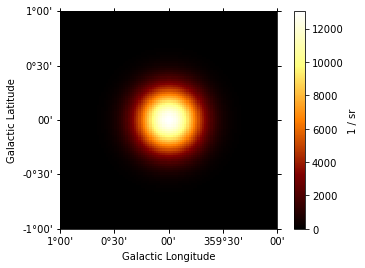

In [28]:
gauss.plot(add_cbar=True);

All spatial models have an associated sky region to it e.g. to illustrate the extend of the model on a sky image. The returned object is an `regions.SkyRegion` object:

In [29]:
print(gauss.to_region())

Region: EllipseSkyRegion
center: <SkyCoord (Galactic): (l, b) in deg
    (0., 0.)>
width: 0.6000000000000001 deg
height: 0.6000000000000001 deg
angle: 0.0 deg


Now we can plot the region on an sky image:

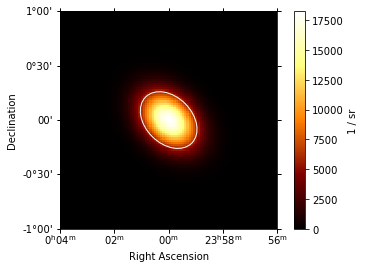

In [30]:
# create and plot the model
gauss_elongated = GaussianSpatialModel(
    lon_0="0 deg", lat_0="0 deg", sigma="0.2 deg", e=0.7, phi="45 deg"
)
ax = gauss_elongated.plot(add_cbar=True)

# add region illustration
region = gauss_elongated.to_region()
region_pix = region.to_pixel(ax.wcs)
ax.add_artist(region_pix.as_artist(ec="w", fc="None"));

The `.to_region()` method can also be useful to write e.g. ds9 region files using `write_ds9` from the `regions` package:

In [31]:
from regions import write_ds9

regions = [gauss.to_region(), gauss_elongated.to_region()]

filename = "regions.reg"
write_ds9(
    regions,
    filename,
    coordsys="galactic",
    fmt=".4f",
    radunit="deg",
    overwrite=True,
)

        Use `regions.Regions.write` instead. [warnings]


In [32]:
!cat regions.reg

# Region file format: DS9 astropy/regions
galactic
ellipse(0.0000,0.0000,0.3000,0.3000,0.0000)
ellipse(96.3373,-60.1886,0.2142,0.3000,45.0000)


## Temporal models

Temporal models are imported from the same `~gammapy.modeling.models` namespace, let's start with a `GaussianTemporalModel`:

In [33]:
from gammapy.modeling.models import GaussianTemporalModel

In [34]:
gauss_temp = GaussianTemporalModel(t_ref=59240.0 * u.d, sigma=2.0 * u.d)
print(gauss_temp)

GaussianTemporalModel

  type    name   value    unit   error   min max frozen link
-------- ----- ---------- ---- --------- --- --- ------ ----
temporal t_ref 5.9240e+04    d 0.000e+00 nan nan  False     
temporal sigma 2.0000e+00    d 0.000e+00 nan nan  False     


To check the `TEMPORAL_MODELS` registry to see which models are available:

In [35]:
from gammapy.modeling.models import TEMPORAL_MODEL_REGISTRY

print(TEMPORAL_MODEL_REGISTRY)

Registry
--------

ConstantTemporalModel           : ['ConstantTemporalModel', 'const'] 
LinearTemporalModel             : ['LinearTemporalModel', 'linear'] 
LightCurveTemplateTemporalModel : ['LightCurveTemplateTemporalModel', 'template'] 
ExpDecayTemporalModel           : ['ExpDecayTemporalModel', 'exp-decay'] 
GaussianTemporalModel           : ['GaussianTemporalModel', 'gauss'] 
GeneralizedGaussianTemporalModel: ['GeneralizedGaussianTemporalModel', 'gengauss'] 
PowerLawTemporalModel           : ['PowerLawTemporalModel', 'powerlaw'] 
SineTemporalModel               : ['SineTemporalModel', 'sinus'] 



Temporal models can be evaluated on `astropy.time.Time` objects. The returned quantity is a dimensionless number

In [36]:
from astropy.time import Time

time = Time("2021-01-29 00:00:00.000")
gauss_temp(time)

<Quantity 0.32465247>

As for other models, they can be plotted in a given time range

<AxesSubplot:xlabel='Time [mjd]', ylabel='Norm / A.U.'>

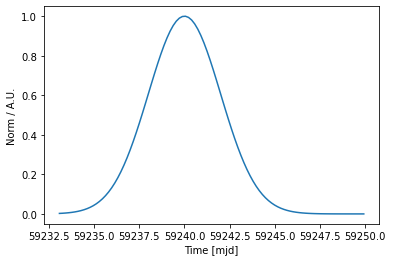

In [37]:
time = Time([59233.0, 59250], format="mjd")
gauss_temp.plot(time)

In [38]:
gauss_temp.is_energy_dependent

False

## SkyModel

The `~gammapy.modeling.models.SkyModel` class combines a spectral, and optionally, a spatial model and a temporal. It can be created
from existing spectral, spatial and temporal model components:

In [39]:
from gammapy.modeling.models import SkyModel

model = SkyModel(
    spectral_model=pwl,
    spatial_model=gauss,
    temporal_model=gauss_temp,
    name="my-source",
)
print(model)

SkyModel

  Name                      : my-source
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : GaussianTemporalModel
  Parameters:
    index                         :      2.200   +/-    0.00             
    amplitude                     :   2.70e-12   +/- 0.0e+00 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lon_0                         :      0.000   +/-    0.00 deg         
    lat_0                         :      0.000   +/-    0.00 deg         
    sigma                         :      0.200   +/-    0.00 deg         
    e                     (frozen):      0.000                   
    phi                   (frozen):      0.000       deg         
    t_ref                         :  59240.000   +/-    0.00 d           
    sigma                         :      2.000   +/-    0.00 d           




It is good practice to specify a name for your sky model, so that you can access it later by name and have meaningful identifier you serilisation. If you don't define a name, a unique random name is generated:

In [40]:
model_without_name = SkyModel(spectral_model=pwl, spatial_model=gauss)
print(model_without_name.name)

5fKKX-kG


The individual components of the source model can be accessed using `.spectral_model`,  `.spatial_model` and `.temporal_model`:

In [41]:
model.spectral_model

In [42]:
model.spatial_model

In [43]:
model.temporal_model

And can be used as you have seen already seen above:

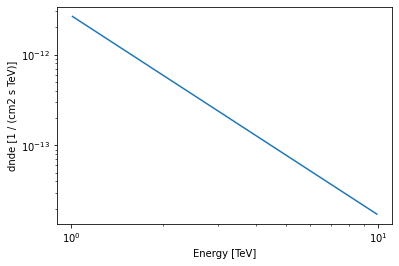

In [44]:
model.spectral_model.plot(energy_bounds=[1, 10] * u.TeV);

Note that the gammapy fitting can interface only with a `SkyModel` and **not** its individual components. So, it is customary to work with `SkyModel` even if you are not doing a 3D fit. Since the amplitude parameter resides on the `SpectralModel`, specifying a spectral component is compulsory. The temporal and spatial components are optional. The temporal model needs to be specified only for timing analysis. In some cases (e.g. when doing a spectral analysis) there is no need for a spatial component either, and only a spectral model is associated with the source. 

In [45]:
model_spectrum = SkyModel(spectral_model=pwl, name="source-spectrum")
print(model_spectrum)

SkyModel

  Name                      : source-spectrum
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : 
  Temporal model type       : 
  Parameters:
    index                         :      2.200   +/-    0.00             
    amplitude                     :   2.70e-12   +/- 0.0e+00 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         




Additionally the spatial model of `~gammapy.modeling.models.SkyModel` can be used to represent source models based on templates, where the spatial and energy axes are correlated. It can be created e.g. from an existing FITS file:



In [46]:
from gammapy.modeling.models import TemplateSpatialModel
from gammapy.modeling.models import PowerLawNormSpectralModel

In [47]:
diffuse_cube = TemplateSpatialModel.read(
    "$GAMMAPY_DATA/fermi-3fhl-gc/gll_iem_v06_gc.fits.gz", normalize=False
)
diffuse = SkyModel(PowerLawNormSpectralModel(), diffuse_cube)
print(diffuse)

SkyModel

  Name                      : 9USui4ME
  Datasets names            : None
  Spectral model type       : PowerLawNormSpectralModel
  Spatial  model type       : TemplateSpatialModel
  Temporal model type       : 
  Parameters:
    norm                          :      1.000   +/-    0.00             
    tilt                  (frozen):      0.000                   
    reference             (frozen):      1.000       TeV         




Note that if the spatial model is not normalized over the sky it has to be combined with a normalized spectral model, for example `~gammapy.modeling.models.PowerLawNormSpectralModel`. This is the only case in `gammapy.models.SkyModel` where the unit is fully attached to the spatial model.

## Modifying model parameters

Model parameters can be modified (eg: frozen, values changed, etc at any point), eg:

In [48]:
# Freezing a parameter
model.spectral_model.index.frozen = True
# Making a parameter free
model.spectral_model.index.frozen = False

In [49]:
# Changing a value
model.spectral_model.index.value = 3

In [50]:
# Setting min and max ranges on parameters
model.spectral_model.index.min = 1.0
model.spectral_model.index.max = 5.0

In [51]:
# Visualise the model as a table
model.parameters.to_table().show_in_notebook()

idx,type,name,value,unit,error,min,max,frozen,link
0,spectral,index,3.0000e+00,,0.000e+00,1.000e+00,5.000e+00,False,
1,spectral,amplitude,2.7000e-12,cm-2 s-1 TeV-1,0.000e+00,nan,nan,False,
2,spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,
3,spatial,lon_0,0.0000e+00,deg,0.000e+00,nan,nan,False,
4,spatial,lat_0,0.0000e+00,deg,0.000e+00,-9.000e+01,9.000e+01,False,
5,spatial,sigma,2.0000e-01,deg,0.000e+00,0.000e+00,nan,False,
6,spatial,e,0.0000e+00,,0.000e+00,0.000e+00,1.000e+00,True,
7,spatial,phi,0.0000e+00,deg,0.000e+00,nan,nan,True,
8,temporal,t_ref,5.9240e+04,d,0.000e+00,nan,nan,False,
9,temporal,sigma,2.0000e+00,d,0.000e+00,nan,nan,False,


You can use the interactive boxes to choose model parameters by name, type or other attrributes mentioned in the column names.

## Model lists and serialisation

In a typical analysis scenario a model consists of multiple model components, or a "catalog" or "source library". To handle this list of multiple model components, Gammapy has a `Models` class:

In [52]:
from gammapy.modeling.models import Models

In [53]:
models = Models([model, diffuse])
print(models)

Models

Component 0: SkyModel

  Name                      : my-source
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : GaussianTemporalModel
  Parameters:
    index                         :      3.000   +/-    0.00             
    amplitude                     :   2.70e-12   +/- 0.0e+00 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lon_0                         :      0.000   +/-    0.00 deg         
    lat_0                         :      0.000   +/-    0.00 deg         
    sigma                         :      0.200   +/-    0.00 deg         
    e                     (frozen):      0.000                   
    phi                   (frozen):      0.000       deg         
    t_ref                         :  59240.000   +/-    0.00 d           
    sigma                         :      2.000   +/-    0.00 d           

Compo

Individual model components in the list can be accessed by their name:

In [54]:
print(models["my-source"])

SkyModel

  Name                      : my-source
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : GaussianTemporalModel
  Parameters:
    index                         :      3.000   +/-    0.00             
    amplitude                     :   2.70e-12   +/- 0.0e+00 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lon_0                         :      0.000   +/-    0.00 deg         
    lat_0                         :      0.000   +/-    0.00 deg         
    sigma                         :      0.200   +/-    0.00 deg         
    e                     (frozen):      0.000                   
    phi                   (frozen):      0.000       deg         
    t_ref                         :  59240.000   +/-    0.00 d           
    sigma                         :      2.000   +/-    0.00 d           




**Note:**To make the access by name unambiguous, models are required to have a unique name, otherwise an error will be thrown.

To see which models are available you can use the `.names` attribute:

In [55]:
print(models.names)

['my-source', '9USui4ME']


Note that a `SkyModel` object can be evaluated for a given longitude, latitude, and energy, but the `Models` object cannot. This `Models` container object will be assigned to `Dataset` or `Datasets` together with the data to be fitted as explained in other analysis tutorials (see for example the [modeling](../analysis/2D/modeling_2D.ipynb) notebook).

The `Models` class also has in place `.append()` and `.extend()` methods:

In [56]:
model_copy = model.copy(name="my-source-copy")
models.append(model_copy)

This list of models can be also serialised to a custom YAML based format: 

In [57]:
models_yaml = models.to_yaml()
print(models_yaml)

Template file already exits, and overwrite is False


components:
-   name: my-source
    type: SkyModel
    spectral:
        type: PowerLawSpectralModel
        parameters:
        -   name: index
            value: 3.0
        -   name: amplitude
            value: 2.7e-12
            unit: cm-2 s-1 TeV-1
        -   name: reference
            value: 1.0
            unit: TeV
            frozen: true
    spatial:
        type: GaussianSpatialModel
        frame: galactic
        parameters:
        -   name: lon_0
            value: 0.0
            unit: deg
        -   name: lat_0
            value: 0.0
            unit: deg
        -   name: sigma
            value: 0.2
            unit: deg
        -   name: e
            value: 0.0
            frozen: true
        -   name: phi
            value: 0.0
            unit: deg
            frozen: true
    temporal:
        type: GaussianTemporalModel
        parameters:
        -   name: t_ref
            value: 59240.0
            unit: d
        -   name: sigma
            value: 2.0

The structure of the yaml files follows the structure of the python objects.
The `components` listed correspond to the `SkyModel` and `SkyDiffuseCube` components of the `Models`. 
For each `SkyModel` we have  information about its `name`, `type` (corresponding to the tag attribute) and sub-mobels (i.e `spectral` model and eventually `spatial` model). Then the spatial and spectral models are defined by their type and parameters. The `parameters` keys name/value/unit are mandatory, while the keys min/max/frozen are optionnals (so you can prepare shorter files).

If you want to write this list of models to disk and read it back later you can use:

In [58]:
models.write("models.yaml", overwrite=True)

Template file already exits, and overwrite is False


In [59]:
models_read = Models.read("models.yaml")

Additionally the models can exported and imported togeter with the data using the `Datasets.read()` and `Datasets.write()` methods as shown in the [analysis_mwl](../analysis/3D/analysis_mwl.ipynb) notebook.

## Models with shared parameter

A model parameter can be shared with other models, for example we can define two power-law models with the same spectral index but different amplitudes: 

In [60]:
pwl2 = PowerLawSpectralModel()
pwl2.index = pwl.index
pwl.index.value = 2.3  # also update pwl2 as the parameter object is now the same as shown below
print(pwl.index)
print(pwl2.index)

Parameter(name='index', value=2.3, factor=2.3, scale=1.0, unit=Unit(dimensionless), min=1.0, max=5.0, frozen=False, id=0x7fbd43aa29e8)
Parameter(name='index', value=2.3, factor=2.3, scale=1.0, unit=Unit(dimensionless), min=1.0, max=5.0, frozen=False, id=0x7fbd43aa29e8)


In the YAML files the shared parameter is flagged by the additional `link` entry that follows the convention `parameter.name@unique_id`:

In [61]:
models = Models(
    [SkyModel(pwl, name="source1"), SkyModel(pwl2, name="source2")]
)
models_yaml = models.to_yaml()
print(models_yaml)

components:
-   name: source1
    type: SkyModel
    spectral:
        type: PowerLawSpectralModel
        parameters:
        -   name: index
            value: 2.3
            link: index@TminMdsw
        -   name: amplitude
            value: 2.7e-12
            unit: cm-2 s-1 TeV-1
        -   name: reference
            value: 1.0
            unit: TeV
            frozen: true
-   name: source2
    type: SkyModel
    spectral:
        type: PowerLawSpectralModel
        parameters:
        -   name: index
            value: 2.3
            link: index@TminMdsw
        -   name: amplitude
            value: 1.0e-12
            unit: cm-2 s-1 TeV-1
        -   name: reference
            value: 1.0
            unit: TeV
            frozen: true



## Implementing a custom model

In order to add a user defined spectral model you have to create a SpectralModel subclass.
This new model class should include:

- a tag used for serialization (it can be the same as the class name)
- an instantiation of each Parameter with their unit, default values and frozen status
- the evaluate function where the mathematical expression for the model is defined.

As an example we will use a PowerLawSpectralModel plus a Gaussian (with fixed width).
First we define the new custom model class that we name `MyCustomSpectralModel`:

In [62]:
from gammapy.modeling import Parameter
from gammapy.modeling.models import SpectralModel


class MyCustomSpectralModel(SpectralModel):
    """My custom spectral model, parametrising a power law plus a Gaussian spectral line.

    Parameters
    ----------
    amplitude : `astropy.units.Quantity`
        Amplitude of the spectra model.
    index : `astropy.units.Quantity`
        Spectral index of the model.
    reference : `astropy.units.Quantity`
        Reference energy of the power law.
    mean : `astropy.units.Quantity`
        Mean value of the Gaussian.
    width : `astropy.units.Quantity`
        Sigma width of the Gaussian line.

    """

    tag = "MyCustomSpectralModel"
    amplitude = Parameter("amplitude", "1e-12 cm-2 s-1 TeV-1", min=0, is_norm=True)
    index = Parameter("index", 2, min=0)
    reference = Parameter("reference", "1 TeV", frozen=True)
    mean = Parameter("mean", "1 TeV", min=0)
    width = Parameter("width", "0.1 TeV", min=0, frozen=True)

    @staticmethod
    def evaluate(energy, index, amplitude, reference, mean, width):
        pwl = PowerLawSpectralModel.evaluate(
            energy=energy,
            index=index,
            amplitude=amplitude,
            reference=reference,
        )
        gauss = amplitude * np.exp(-((energy - mean) ** 2) / (2 * width ** 2))
        return pwl + gauss

It is good practice to also implement a docstring for the model, defining the parameters and also definig a `tag`, which specifies the name of the model for serialisation. Also note that gammapy assumes that all SpectralModel evaluate functions return a flux in unit of `"cm-2 s-1 TeV-1"` (or equivalent dimensions).



This model can now be used as any other spectral model in Gammapy:

In [63]:
my_custom_model = MyCustomSpectralModel(mean="3 TeV")
print(my_custom_model)

MyCustomSpectralModel

  type      name     value         unit        error      min    max frozen link
-------- --------- ---------- -------------- --------- --------- --- ------ ----
spectral amplitude 1.0000e-12 cm-2 s-1 TeV-1 0.000e+00 0.000e+00 nan  False     
spectral     index 2.0000e+00                0.000e+00 0.000e+00 nan  False     
spectral reference 1.0000e+00            TeV 0.000e+00       nan nan   True     
spectral      mean 3.0000e+00            TeV 0.000e+00 0.000e+00 nan  False     
spectral     width 1.0000e-01            TeV 0.000e+00 0.000e+00 nan   True     


In [64]:
my_custom_model.integral(1 * u.TeV, 10 * u.TeV)

<Quantity 1.14427393e-12 1 / (cm2 s)>

<AxesSubplot:xlabel='Energy [TeV]', ylabel='dnde [1 / (cm2 s TeV)]'>

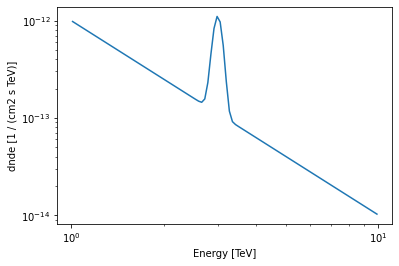

In [65]:
my_custom_model.plot(energy_bounds=[1, 10] * u.TeV)

As a next step we can also register the custom model in the `SPECTRAL_MODELS` registry, so that it becomes available for serilisation:

In [66]:
SPECTRAL_MODEL_REGISTRY.append(MyCustomSpectralModel)

In [67]:
model = SkyModel(spectral_model=my_custom_model, name="my-source")
models = Models([model])
models.write("my-custom-models.yaml", overwrite=True)

In [68]:
!cat my-custom-models.yaml

components:
-   name: my-source
    type: SkyModel
    spectral:
        type: MyCustomSpectralModel
        parameters:
        -   name: amplitude
            value: 1.0e-12
            unit: cm-2 s-1 TeV-1
        -   name: index
            value: 2.0
        -   name: reference
            value: 1.0
            unit: TeV
            frozen: true
        -   name: mean
            value: 3.0
            unit: TeV
        -   name: width
            value: 0.1
            unit: TeV
            frozen: true
covariance: my-custom-models_covariance.dat


Similarly you can also create custom spatial models and add them to the `SPATIAL_MODELS` registry. In that case gammapy assumes that the evaluate function return a normalized quantity in "sr-1" such as the model integral over the whole sky is one.

## Models with energy dependent morphology

A common science case in the study of extended sources is to probe for energy dependent morphology, eg: in Supernova Remnants or Pulsar Wind Nebulae. Traditionally, this has been done by splitting the data into energy bands and doing individual fits of the morphology in these energy bands.

`SkyModel` offers a natural framework to simultaneously model the energy and morphology, e.g. spatial extent described by a parametric model expression with energy dependent parameters.

The models shipped within gammapy use a “factorised” representation of the source model, where the spatial ($l,b$), energy ($E$) and time ($t$) dependence are independent model components and not correlated:

   $$f(l, b, E, t) = F(l, b) \cdot G(E) \cdot H(t) $$
    
To use full 3D models, ie $f(l, b, E) = F(l, b, E) \cdot G(E) $,  you have to implement your own custom `SpatialModel`. Note that it is still necessary to multiply by a `SpectralModel`, $G(E)$ to be dimensionally consistent.

In this example, we create Gaussian Spatial Model with the extension varying with energy. For simplicity, we assume a linear dependence on energy and parameterize this by specifying the extension at 2 energies. You can add more complex dependences, probably motivated by physical models.

In [69]:
from gammapy.modeling.models import SpatialModel
from astropy.coordinates.angle_utilities import angular_separation


class MyCustomGaussianModel(SpatialModel):
    """My custom Energy Dependent Gaussian model.

    Parameters
    ----------
    lon_0, lat_0 : `~astropy.coordinates.Angle`
        Center position
    sigma_1TeV : `~astropy.coordinates.Angle`
        Width of the Gaussian at 1 TeV
    sigma_10TeV : `~astropy.coordinates.Angle`
        Width of the Gaussian at 10 TeV

    """

    tag = "MyCustomGaussianModel"
    is_energy_dependent = True
    lon_0 = Parameter("lon_0", "0 deg")
    lat_0 = Parameter("lat_0", "0 deg", min=-90, max=90)

    sigma_1TeV = Parameter("sigma_1TeV", "2.0 deg", min=0)
    sigma_10TeV = Parameter("sigma_10TeV", "0.2 deg", min=0)

    @staticmethod
    def evaluate(lon, lat, energy, lon_0, lat_0, sigma_1TeV, sigma_10TeV):

        sep = angular_separation(lon, lat, lon_0, lat_0)

        # Compute sigma for the given energy using linear interpolation in log energy
        sigma_nodes = u.Quantity([sigma_1TeV, sigma_10TeV])
        energy_nodes = [1, 10] * u.TeV
        log_s = np.log(sigma_nodes.to("deg").value)
        log_en = np.log(energy_nodes.to("TeV").value)
        log_e = np.log(energy.to("TeV").value)
        sigma = np.exp(np.interp(log_e, log_en, log_s)) * u.deg

        exponent = -0.5 * (sep / sigma) ** 2
        norm = 1 / (2 * np.pi * sigma ** 2)
        return norm * np.exp(exponent)

Serialisation of this model can be achieved as explained in the previous section.
You can now use it as stadard `SpatialModel` in your analysis. Note that this is still a `SpatialModel`, and not a `SkyModel`, so it needs to be multiplied by a `SpectralModel` as before. 

In [70]:
spatial_model = MyCustomGaussianModel()
spectral_model = PowerLawSpectralModel()
sky_model = SkyModel(
    spatial_model=spatial_model, spectral_model=spectral_model
)

In [71]:
spatial_model.evaluation_radius

To visualise it, we evaluate it on a 3D geom. 

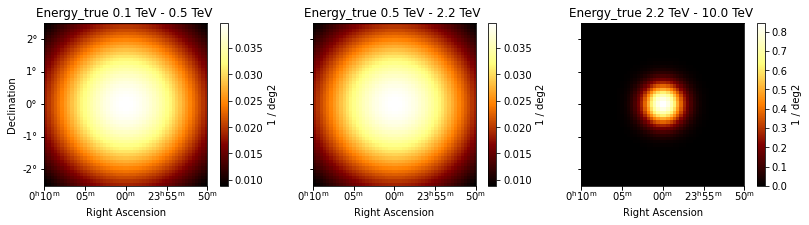

In [72]:
energy_axis = MapAxis.from_energy_bounds(
    energy_min=0.1 * u.TeV, energy_max=10.0 * u.TeV, nbin=3, name="energy_true"
)
geom = WcsGeom.create(
    skydir=(0, 0), width=5.0 * u.deg, binsz=0.1, axes=[energy_axis]
)

spatial_model.plot_grid(geom=geom, add_cbar=True, figsize=(14, 3));

For computational purposes, it is useful to specify a `evaluation_radius` for `SpatialModels` - this gives a size on which to compute the model. Though optional, it is highly recommended for Custom Spatial Models. This can be done, for ex, by defining the following function **inside** the above class:

In [73]:
@property
def evaluation_radius(self):
    """Evaluation radius (`~astropy.coordinates.Angle`)."""
    return 5 * np.max([self.sigma_1TeV.value, self.sigma_10TeV.value]) * u.deg

## Spectrally Varying Temporal Model

In [106]:
from gammapy.modeling.models import TemporalModel
from gammapy.data.gti import GTI
import scipy


class MyCustomTemporalModel(TemporalModel):
    """Spectrally varying temporal model where the index depends time

    F(t) = exp(-(t - t_ref)/t0) * (E/E0)^-\alpha

    where \alpha = (\alpha_0 t/t_ref)^-beta

    Parameters
    ----------

    beta: `~astropy.units.Quantity`
        temporal index of spectrum
    t0 : `~astropy.units.Quantity`
        Decay time scale
    t_ref : `~astropy.units.Quantity`
        The reference time in mjd.
    E0: `~astropy.units.Quantity`
        reference energy

    """

    tag = "MyCustomTemporalModel"
    is_energy_dependent = True
    beta = Parameter("beta", 0.2)
    t0 = Parameter("t0", "1 d", frozen=False)
    _t_ref_default = Time("2000-01-01")
    t_ref = Parameter("t_ref", _t_ref_default.mjd, unit="day", frozen=True)
    E0 = Parameter("E0", "1 TeV", frozen=True)

    @staticmethod
    def evaluate(time, energy, t0, t_ref, beta, E0):
        alpha = np.power((time/t_ref), -beta)
        return np.exp(-(time - t_ref) / t0) * np.power((energy / E0), -alpha)

    def integral(self, t_min, t_max, energy):
        pars = self.parameters
        t0 = pars["t0"].quantity.to("d").value
        t_ref = Time(pars["t_ref"].quantity, format="mjd")
        beta = pars["beta"].quantity
        E0 = pars["E0"].quantity
        integral = []
        for t1, t2 in zip(t_min,t_max):
            integral.append(scipy.integrate.quad(func=self.evaluate,
                                            a=t1.mjd,
                                            b=t2.mjd,
                                            args=(energy, t0, t_ref.mjd, beta, E0)
                                           )[0]
                           )
        print(integral, self.time_sum(t_min, t_max).to_value("d"))
        return integral / self.time_sum(t_min, t_max).to_value("d")
        

In [107]:
temporal_model = MyCustomTemporalModel()

In [108]:
temporal_model.is_energy_dependent

True

In [109]:
from gammapy.modeling.models import ConstantSpectralModel

In [110]:
model = SkyModel(
    spectral_model=ConstantSpectralModel(), temporal_model=temporal_model
)
model.parameters.to_table()

[0.23237147192011487] 1.0


type,name,value,unit,error,min,max,frozen,link
str8,str5,float64,str14,int64,float64,float64,bool,str1
spectral,const,1.0000e-12,cm-2 s-1 TeV-1,0.000e+00,nan,nan,False,
temporal,beta,2.0000e-01,,0.000e+00,nan,nan,False,
temporal,t0,1.0000e+00,d,0.000e+00,nan,nan,False,
temporal,t_ref,5.1544e+04,d,0.000e+00,nan,nan,True,
temporal,E0,1.0000e+00,TeV,0.000e+00,nan,nan,True,


In [88]:
model = SkyModel(
        spectral_model=ConstantSpectralModel(), temporal_model=temporal_model
    )

[0.9999999999999999] 1.0


In [89]:

model.evaluate(lon=0, lat=0, energy=energy[0], time=t_ref + start)

<Quantity [3.27416183e-12, 3.27412269e-12, 3.27409473e-12] 1 / (cm2 s TeV)>